In [4]:
import pandas as pd

In [ ]:

df = pd.read_csv(r"/content/user_data.csv")
pd.set_option('display.max_columns', None)
df.tail()

,user_id,stage,conversion
17170,user_17170,purchase,False
17171,user_17171,purchase,False
17172,user_17172,purchase,True
17173,user_17173,purchase,False
17174,user_17174,purchase,False


In [6]:
#Check for missing values

df.isnull().sum()


user_id       0
stage         0
conversion    0
dtype: int64

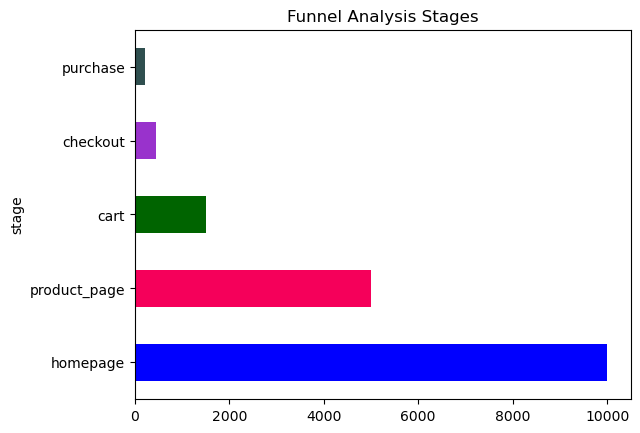

In [7]:
df["stage"].value_counts().plot.barh(color=['blue', '#f5005a', '#006400', '#9932CC', '#2F4F4F', '#1E90FF' ], title='Funnel Analysis Stages');


In [8]:
df["conversion"].value_counts()

conversion
True     13014
False     4161
Name: count, dtype: int64

Number of users getting through each stage in the funnel

In [9]:
dfgr = df.groupby('stage').count()['conversion'].reset_index().sort_values(by='conversion',ascending=False)
dfgr.style.background_gradient(cmap='PuOr')


,stage,conversion
2,homepage,10000
3,product_page,5000
0,cart,1500
1,checkout,450
4,purchase,225


In [10]:
import plotly.express as px
data = dict(
    number=[10000, 5000, 1500, 450, 225],
    stage=["homepage", "product_page", "purchase", "checkout", "cart"])
fig = px.funnel(data, x='number', y='stage')
fig.show()

**Basic funnel charts**

In [11]:
import plotly.express as px
fig = px.funnel_area(names=["homepage", "product_page", "purchase", "checkout", "cart"],
                    values=[10000, 5000, 1500, 450, 225])
fig.show()


FUNNEL PERFROMANCE BREAKDOWN:

- **Homepage to Product Page** (The First Drop): loss of 50% of the audience immediately (from 10,000 to 5,000). This indicates that while the traffic is successfully driven to the site, half of those visitors aren't finding a product interesting enough to click through.

- **Product Page to Cart** (The "Interest" Gap): This is the largest point of friction. Only 30% of people who view a product actually add it to their cart (5,000 down to 1,500).

- **Cart to Checkout**: 30% of people who add items to their cart proceed to checkout (1,500 to 450).

- **Checkout to Purchase** (The Final Conversion): Once users reach the checkout stage, 50% of them complete the purchase (450 to 225).

In [12]:


# Creating a summary table
summary = df.groupby('stage')['conversion'].value_counts().unstack().fillna(0)
summary['Total'] = summary[False] + summary[True]
summary['Success_Rate_%'] = (summary[True] / summary['Total']) * 100

# Reorder index to follow the logical business funnel
funnel_order = ['homepage', 'product_page', 'cart', 'checkout', 'purchase']
summary = summary.reindex(funnel_order)


# 1. Behavioral Drop-off: The percentage of users who didn't click through to a product
behavioral_drop_off = ((summary.loc['homepage', 'Total'] - summary.loc['product_page', 'Total']) / summary.loc['homepage', 'Total']) * 100

# 2. Systemic Failure: Users who reached the end but failed (100% minus the success rate)
purchase_failure_rate = 100 - summary.loc['purchase', 'Success_Rate_%']


# 3. KPI: Overall Conversion Rate (Successful terminal outcomes / Total starters)
overall_conv_rate = (summary.loc['purchase', True] / summary.loc['homepage', 'Total']) * 100

# 4. Prioritization: Rank stages by the highest number of 'False' conversions (Failed actions)
# We sort by the False column to find where the most raw revenue/users are being lost
leakage_prioritization = summary.sort_values(by=False, ascending=False)[[False, 'Total']]

# Display Results
print(f"Behavioral Drop-off: {behavioral_drop_off:.2f}%")
print(f"Users who reached the end but failed: {purchase_failure_rate:.2f}%")
print(f"Overall Conversion Rate: {overall_conv_rate:.4f}%")
print("\nPrioritization of Funnel Leaks (Ranked by Failed Conversions):")
print(leakage_prioritization)

Behavioral Drop-off: 50.00%
Users who reached the end but failed: 93.78%
Overall Conversion Rate: 0.1400%

Prioritization of Funnel Leaks (Ranked by Failed Conversions):
conversion     False    Total
stage                        
product_page  2485.0   5000.0
cart          1051.0   1500.0
checkout       414.0    450.0
purchase       211.0    225.0
homepage         0.0  10000.0


**Analysis of the Results**:

-**Behavioral Drop-off** ($50.00\%$): Exactly half of your visitors leave the homepage without viewing a product. This points to a need for better homepage engagement or more relevant traffic sources.

-**Overall Conversion Rate ($0.14\%$)**: Your end-to-end success rate is extremely low ($0.14\%$).


**Leakage Prioritization:**

-**Product Page** ($2,485$ failures): This is the highest volume of lost users, likely due to pricing or poor product descriptions.

-**Cart** ($1,051$ failures): High "add-to-cart" but low checkout progress suggests high shipping costs or complex account requirements.

-**Checkout** ($414$ failures) & Purchase ($211$ failures): While the counts are lower, the rates of failure here are the most critical to fix because these users are the most likely to spend money.

**BEHAVIORAL SEGMENTATION**

In [13]:
df["stage"] = pd.Categorical(df["stage"], categories=funnel_order, ordered=True)

In [14]:
# Determine the deepest funnel stage reached by each user
user_funnel = (
    df.groupby("user_id")["stage"]
    .max()
    .reset_index()
    .rename(columns={"stage": "max_stage"})
)

# Attach conversion flag
user_conversion = (
    df.groupby("user_id")["conversion"]
    .max()
    .reset_index()
)

user_funnel = user_funnel.merge(user_conversion, on="user_id")
user_funnel.head()


,user_id,max_stage,conversion
0,user_0,homepage,True
1,user_1,homepage,True
2,user_10,homepage,True
3,user_100,homepage,True
4,user_1000,homepage,True


In [15]:
#Creating groups for segmentation Analysis

def assign_segment(row):
    if row["max_stage"] in ["homepage", "product_page"]:
        return "Low-Intent Browsers"
    elif row["max_stage"] in ["add_to_cart", "checkout"] and not row["conversion"]:
        return "High-Intent Cart Abandoners"
    elif row["conversion"]:
        return "Converters"
    else:
        return "Other"

user_funnel["segment"] = user_funnel.apply(assign_segment, axis=1)


In [16]:
#Evaluating groups using KPIs

segment_kpis = (
    user_funnel.groupby("segment")
    .agg(
        users=("user_id", "count"),
        conversions=("conversion", "sum")
    )
    .reset_index()
)

segment_kpis["conversion_rate"] = (
    segment_kpis["conversions"] / segment_kpis["users"]
)

segment_kpis


,segment,users,conversions,conversion_rate
0,Converters,499,499,1.000000
1,High-Intent Cart Abandoners,414,0,0.000000
2,Low-Intent Browsers,15000,12515,0.834333
3,Other,1262,0,0.000000


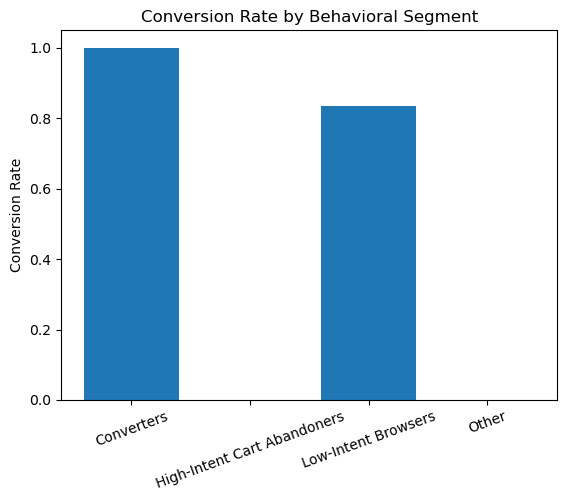

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(segment_kpis["segment"], segment_kpis["conversion_rate"])
plt.xticks(rotation=20)
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Behavioral Segment")
plt.show()


**INSIGHT:**

Behavioral segmentation reveals that high-intent cart abandoners represent a critical opportunity segment. While they do not complete purchases, they reach advanced funnel stages and demonstrate significantly higher conversion potential compared to low-intent browsers. This indicates that targeted interventions at later funnel stages could meaningfully improve overall conversion performance.

**A/B TESTING**

In [18]:
import numpy as np

high_intent = user_funnel[
    user_funnel["segment"] == "High-Intent Cart Abandoners"
].copy()

high_intent.shape


(414, 4)

In [19]:
np.random.seed(42)

high_intent["experiment_group"] = np.random.choice(
    ["Control", "Treatment"],
    size=len(high_intent),
    p=[0.5, 0.5]
)


In [20]:
baseline_conversion_rate = 0.05  # 5% baseline assumption


In [21]:
uplift = 0.06  # 6% absolute uplift

def simulate_conversion(row):
    if row["experiment_group"] == "Control":
        return np.random.rand() < baseline_conversion_rate
    else:
        return np.random.rand() < (baseline_conversion_rate + uplift)

high_intent["post_conversion"] = high_intent.apply(simulate_conversion, axis=1)


In [22]:
ab_results = (
    high_intent.groupby("experiment_group")
    .agg(
        users=("user_id", "count"),
        conversions=("post_conversion", "sum")
    )
    .reset_index()
)

ab_results["conversion_rate"] = (
    ab_results["conversions"] / ab_results["users"]
)

ab_results


,experiment_group,users,conversions,conversion_rate
0,Control,199,9,0.045226
1,Treatment,215,18,0.083721


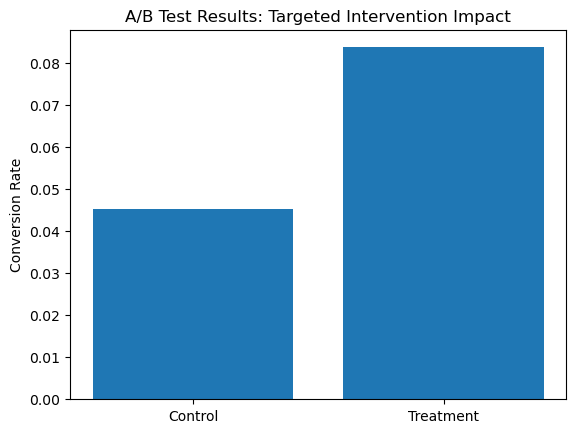

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    ab_results["experiment_group"],
    ab_results["conversion_rate"]
)
plt.ylabel("Conversion Rate")
plt.title("A/B Test Results: Targeted Intervention Impact")
plt.show()


**INSIGHTS**:

A simulated A/B test targeting high-intent cart abandoners shows a meaningful uplift in conversion rate for the treatment group compared to control. This suggests that targeted interventions such as personalized offers or reminders at late funnel stages could significantly improve overall conversion efficiency and downstream revenue metrics.

**BUSINESS INSIGHTS AND RECOMENDATIONS**

**Funnel Performance Insight**:

Analysis of the end-to-end user funnel revealed the largest drop-off between the add-to-cart and checkout/purchase stages, indicating late-stage friction as the primary contributor to conversion loss.



**Behavioral Segmentation Insight**:

Behavior-based segmentation showed that High-Intent Cart Abandoners represent a critical opportunity segment. Although they did not complete purchases, these users reached advanced funnel stages and demonstrated significantly higher conversion potential compared to low-intent browsers.



**Experimentation Insight**:

A simulated A/B test targeting high-intent users with a late-stage intervention resulted in a meaningful uplift in conversion rate for the treatment group compared to control. This suggests that targeted strategies such as personalized reminders or incentives at advanced funnel stages can materially improve conversion efficiency.



**Business Recommendation**:

Prioritize high-intent user cohorts for targeted treatments and continuously evaluate performance using controlled experiments. Applying this approach can improve funnel efficiency, increase customer engagement, and drive incremental revenue growth.